<a href="https://colab.research.google.com/github/Dhaneesh02/Project_1/blob/presentation/Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pickle
import numpy as np

from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MFCC Augmented

Max Validated Accuracy:  0.72249445104599


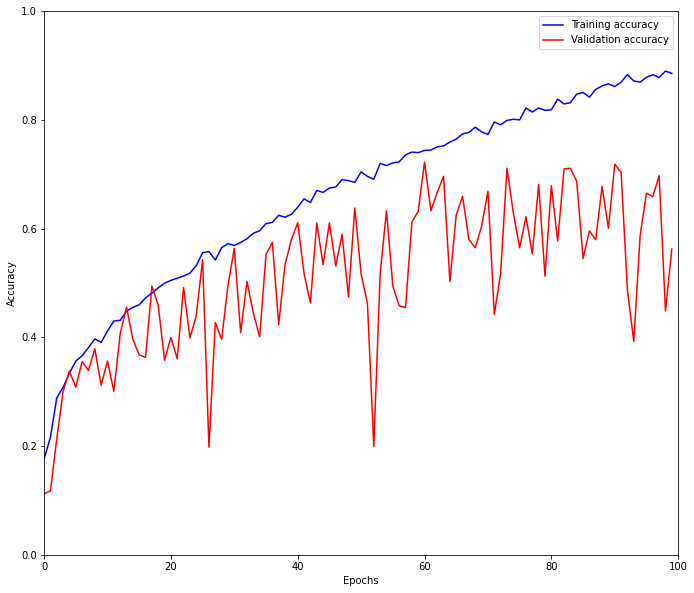

In [17]:
import pandas
history = {} 
history["history"] = pandas.read_csv('/content/drive/MyDrive/FYP/Pickle/source_history.csv') 
history["history"].head()
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
print("Max Validated Accuracy: ",max(history['history']['val_accuracy']))

Max Validated Accuracy:  0.7432377883911133


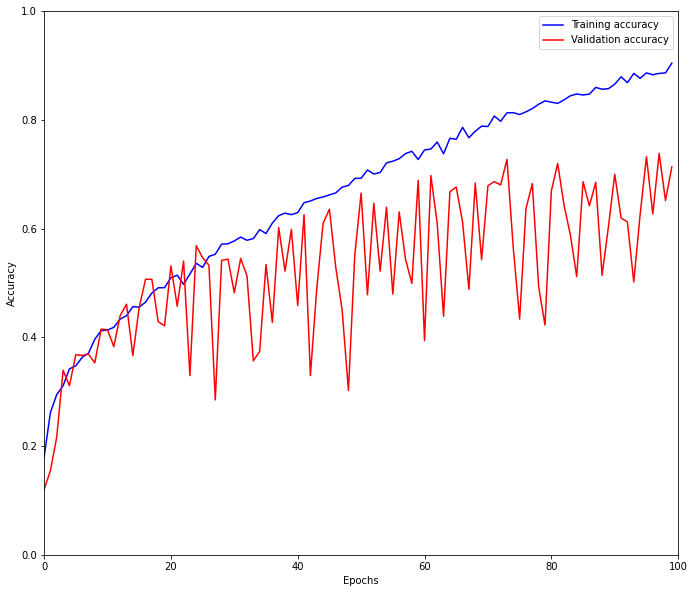

In [18]:
import pandas
history = {} 
history["history"] = pandas.read_csv('/content/drive/MyDrive/FYP/Pickle/gfcc_sgd_source_history.csv') 
history["history"].head()
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
print("Max Validated Accuracy: ",max(history['history']['val_accuracy']))

Max Validated Accuracy:  0.6096654534339905


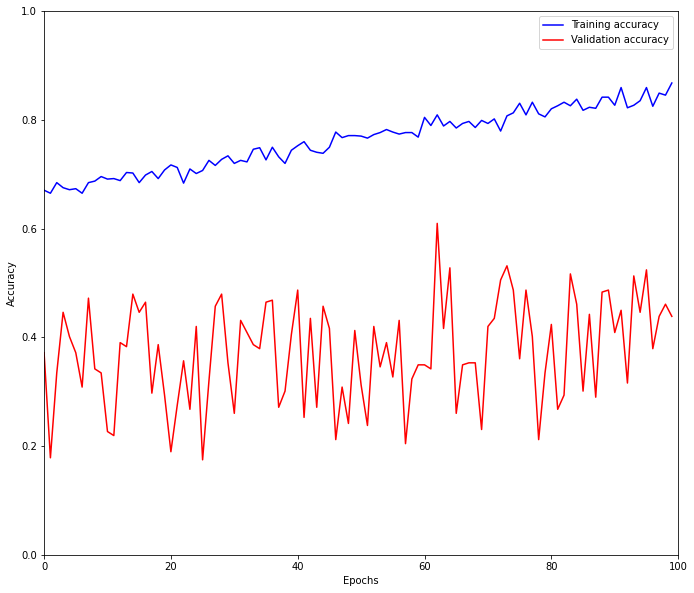

In [20]:
import pandas
history = {} 
history["history"] = pandas.read_csv('/content/drive/MyDrive/FYP/Pickle/unaugmented_history.csv') 
history["history"].head()
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Validation accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
print("Max Validated Accuracy: ",max(history['history']['val_accuracy']))

In [4]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline
### Graph imports ###
from PIL import Image
import librosa
### Audio import ###

import IPython
from IPython.display import Audio

In [5]:
# RAVDESS Database
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}
#data_visualistion
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:8])
    if gender_differentiation == True:
        if int(audio_file[18:20])%2 == 0: # Female
            label = 'female_' + label
        if int(audio_file[18:20])%2 == 1: # Male
            label = 'male_' + label
    return label

In [7]:
file_path = '/content/drive/MyDrive/FYP/RAVDESS/'

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (3.0 sec)
max_pad_len = 49100

file_name_list=[]

signal=file_names=lebels=None
signal=pickle.load(open("/content/drive/MyDrive/Pickle/sample.p","rb"))
file_name=pickle.load(open("/content/drive/MyDrive/Pickle/file_names.p","rb"))
labels=pickle.load(open("/content/drive/MyDrive/Pickle/labels.p","rb"))

print(len(signal),len(file_name),len(labels))
#data_visualisation
count = len(signal)
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))


1344 1440 1344
Import Data: END 

Number of audio files imported: 1344


In [9]:
# Number of augmented data
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    print('noise')
    noise = np.random.normal(size=(nb_augmented, signal_len))
    IPython.display.display(Audio(noise[0], rate=sample_rate))
    IPython.display.display(Audio(noise[1], rate=sample_rate))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise
print('original')
IPython.display.display(Audio(signal[0], rate=sample_rate))
temp=noisy_signal(signal[0])
print('output')
IPython.display.display(Audio(temp[0], rate=sample_rate))
IPython.display.display(Audio(temp[1], rate=sample_rate))
print('label: ',labels[0])

original


noise


output


label:  NEU


noise


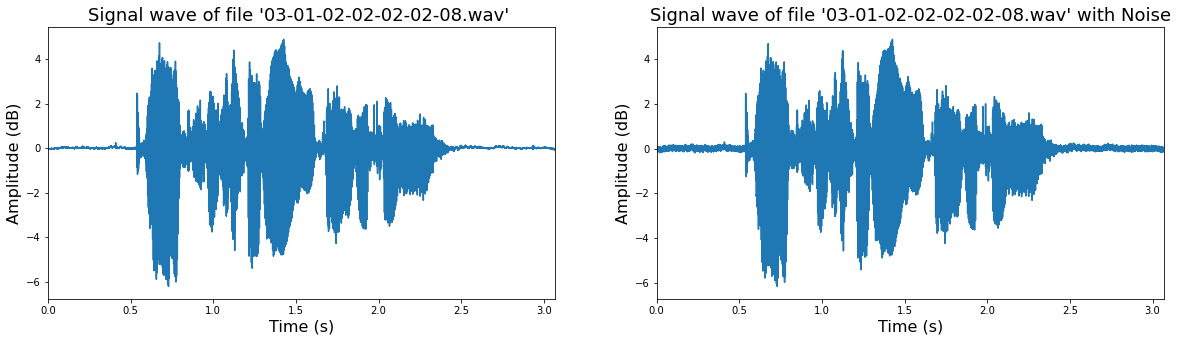

Audio file '03-01-02-02-02-02-08.wav':


Audio file '03-01-02-02-02-02-08.wav' with noise:


In [16]:
random_idx=0
augmented_signal=[]
augmented_signal.append(noisy_signal(signal[0]))
random_filename=file_name[0]
random_signal=signal[0]
# Plot signal wave
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' ".format(random_filename), fontsize=18)

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signal[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with Noise".format(random_filename), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
IPython.display.display(Audio(random_signal, rate=sample_rate))

# Play same audio file with noise
print("Audio file '{}' with noise:".format(random_filename))
IPython.display.display(Audio(augmented_signal[random_idx][0], rate=sample_rate))